In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

In [2]:
data = pd.read_csv('houseprice.csv')

In [3]:
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
categorical = [var for var in data.columns if data[var].dtype == 'O']
year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]
discrete = [var for var in data.columns if data[var].dtype != 'O'
            and len(data[var].unique()) < 20 and var not in year_vars
    ]
continuous = [var for var in data.columns if data[var].dtype != 'O'
              if var not in discrete and var not in ['Id', 'SalePrice']
              and var not in year_vars
    ]

In [5]:
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} temporal variables'.format(len(year_vars)))

There are 43 categorical variables
There are 14 discrete variables
There are 18 continuous variables
There are 4 temporal variables


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'],
                                                    test_size=0.1, random_state=0)

In [7]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [8]:
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [9]:
final_columns = X_train.columns

In [10]:
X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [12]:
year_vars.remove('YrSold')

for col in discrete+continuous+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


In [13]:
for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

Alley 0.9383561643835616
MasVnrType 0.0045662100456621
BsmtQual 0.0243531202435312
BsmtCond 0.0243531202435312
BsmtExposure 0.02511415525114155
BsmtFinType1 0.0243531202435312
BsmtFinType2 0.02511415525114155
Electrical 0.00076103500761035
FireplaceQu 0.4726027397260274
GarageType 0.0563165905631659
GarageFinish 0.0563165905631659
GarageQual 0.0563165905631659
GarageCond 0.0563165905631659
PoolQC 0.9954337899543378
Fence 0.8143074581430746
MiscFeature 0.9611872146118722


In [63]:
house_pipe = Pipeline([
    ('missing_ind', mdi.AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(tol=0.01, n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.OrdinalCategoricalEncoder(encoding_method='ordered', variables=categorical+discrete)),
    ('discretisation', dsc.EqualFrequencyDiscretiser(q=5, return_object=True, variables=continuous)),
    ('encoding', ce.OrdinalCategoricalEncoder(encoding_method='ordered', variables=continuous)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=0))
    
])

In [64]:
house_pipe.fit(X_train, y_train)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('missing_ind', AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])), ('imputer_num', MeanMedianImputer(imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])), ('imputer_cat', CategoricalVariableImputer(variables=['MSZoning', 'Str...tive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [65]:
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [66]:
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print('\n')
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train rmse: 30476.555841700872
train r2: 0.8512419177305749


test rmse: 41155.3019001042
test r2: 0.7535316559983922


In [68]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, figsize=(12,7))

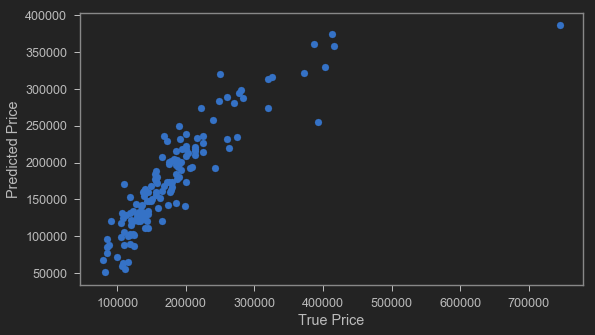

In [74]:
plt.figure(figsize=(9,5))
plt.scatter(y_test, X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price');


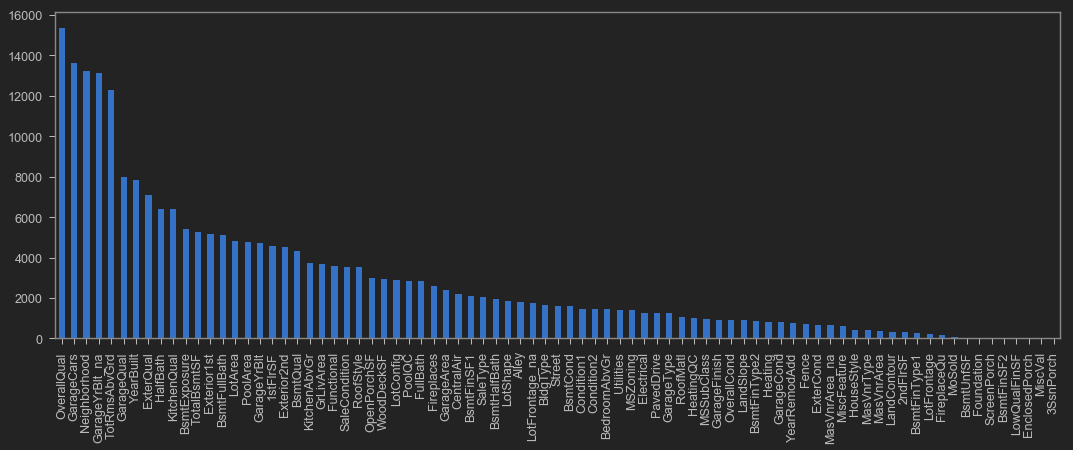

In [83]:
importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns) + ['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']
importance.sort_values(ascending=False, inplace=True)
importance.plot.bar(figsize=(18,6));